# Binary Prediction of Poisonous Mushrooms

Playground Series - Season 4, Episode 8

(https://www.kaggle.com/competitions/playground-series-s4e8)

![image](./data/header.png)

__Overview__
Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

__Your Goal:__ The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.

__Dataset Description__
The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

__Note:__ Unlike many previous Tabular Playground datasets, data artifacts have not been cleaned up. There are categorical values in the dataset that are not found in the original. It is up to the competitors how to handle this.

__Files (297.82 MB)__

- train.csv - the training dataset; class is the binary target (either e or p)
- test.csv - the test dataset; your objective is to predict target class for each row
- sample_submission.csv - a sample submission file in the correct format

__Models__
- K-Nearest Neighboor Model 
- Gaussian Naive Bayes Model 
- Logistic Regressor 
- Support Vector Classification Model 
- Decision Tree Model 
- Random Forest Model 
- Linear Discriminant Analysis Model 
- Gradient Boosting Classifier Model 
- Neural Network CLassifier Model 
- X Gradient Boost Classifier
- Cat Boosting Classifier
- Ada Boosting Classifier
- Quadratic Discriminant Analysis
- Perceptron Classifier Model
- Ridge Classifier Model
- Logistic Regression CV
- Bagging Classifier Model
- Extra Trees Classifier
- Passive Aggressive Classifier
- Hist Gradient Boosting Classifier

In [2]:
%pip install --upgrade pip --break-system-packages
%pip install -r requirements.txt --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Import all necessary libraries

import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import datetime as dt
import warnings as wn
import matplotlib.pyplot as plt

from catboost import Pool
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [20]:
# Ignore all warnings
wn.filterwarnings('ignore')

In [21]:
# Set all variables paths 

_plots = './plots/'
_tested = './tested/'
_test = './data/test.csv'
_train = './data/train.csv'
_info = './model/model.docx'
_model = './model/model.pkl'
_submission = './data/sample_submission.csv'

In [22]:
# Simplify the process of integrating large CSV

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file, **kwargs):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, **kwargs)
    df = reduce_mem_usage(df)
    return df

In [23]:
# Read the training and testing datasets and preprocess
train = import_data(_train, index_col = "id", engine="pyarrow")

Memory usage of dataframe is 523.17 MB
Memory usage after optimization is: 95.15 MB
Decreased by 81.8%


In [24]:
# Set the datatype of each column for memory eficiency

for col in train.columns:
    if train[col].dtype == 'category':
        print(f'Column {col} has {train[col].nunique()} unique values')

Column class has 2 unique values
Column cap-shape has 75 unique values
Column cap-surface has 84 unique values
Column cap-color has 79 unique values
Column does-bruise-or-bleed has 27 unique values
Column gill-attachment has 79 unique values
Column gill-spacing has 49 unique values
Column gill-color has 64 unique values
Column stem-root has 39 unique values
Column stem-surface has 61 unique values
Column stem-color has 60 unique values
Column veil-type has 23 unique values
Column veil-color has 25 unique values
Column has-ring has 24 unique values
Column ring-type has 41 unique values
Column spore-print-color has 33 unique values
Column habitat has 53 unique values
Column season has 4 unique values


In [25]:
# Display the first n rows of training
train.head(n=10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.796875,f,s,u,f,a,c,w,4.511719,...,,,w,,,f,f,,d,a
1,p,4.511719,x,h,o,f,a,c,n,4.789062,...,,y,o,,,t,z,,d,w
2,e,6.941406,f,s,b,f,x,c,w,6.851562,...,,s,n,,,f,f,,l,w
3,e,3.880859,f,y,g,f,s,,g,4.160156,...,,,w,,,f,f,,d,u
4,e,5.851562,x,l,w,f,d,,w,3.369141,...,,,w,,,f,f,,g,a
5,p,4.300781,x,t,n,f,s,c,n,5.910156,...,,,w,,n,t,z,,d,a
6,e,9.648438,p,y,w,f,e,c,k,19.062500,...,,s,w,,,t,e,,g,w
7,p,4.550781,x,e,e,f,a,,y,8.312500,...,,,y,,w,t,z,,d,a
8,p,7.359375,f,h,e,f,x,d,w,5.769531,...,b,,w,,,f,f,,d,a


In [26]:
# Describe the data
train.describe(include=['category']).T

,count,unique,top,freq
class,3116945,2,p,1705396
cap-shape,3116945,75,x,1436026
cap-surface,3116945,84,,671023
cap-color,3116945,79,n,1359542
does-bruise-or-bleed,3116945,27,f,2569743
gill-attachment,3116945,79,a,646034
gill-spacing,3116945,49,c,1331054
gill-color,3116945,64,w,931538
stem-root,3116945,39,,2757023
stem-surface,3116945,61,,1980861


In [27]:
# Display more info about the data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 category
 1   cap-diameter          float16 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-spacing          category
 8   gill-color            category
 9   stem-height           float16 
 10  stem-width            float16 
 11  stem-root             category
 12  stem-surface          category
 13  stem-color            category
 14  veil-type             category
 15  veil-color            category
 16  has-ring              category
 17  ring-type             category
 18  spore-print-color     category
 19  habitat               category
 20  season                category
dtypes: category(18), float16(3)
memory usage: 95.2 MB


In [28]:
# Verify if there are null values
print(train.isnull().sum())
train = train.dropna()

class                   0
cap-diameter            4
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64


In [29]:
# Check for dublicates
print(train.duplicated().sum())
train.drop_duplicates()

119


In [16]:
# Set the columns names
names = train.columns
names

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [30]:
# Check for outliers

def remove_outliers(df):

    outliers_columns = []
    total_rows = len(df)
    
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        outlier_count = outliers.sum()
        outlier_percentage = (outlier_count / total_rows) * 100
        
        if outlier_percentage >= 20:
            outliers_columns.append(column)
            print(f"Outliers detected in column '{column}': {outlier_percentage:.2f}% of total rows.")
            
            df = df[~outliers]
            print(f"Removed {outlier_count} outliers from column '{column}'.")
    
    if not outliers_columns:
        print("No columns with outliers exceeding 20% detected.")

    return df
    
train = remove_outliers(train)

No columns with outliers exceeding 20% detected.


In [31]:
# Encode the string training data

for column in train.columns[:]:
    if train[column].dtype == 'category':   
        encoder = LabelEncoder()
        train[column] = encoder.fit_transform(train[column]) + 1
        mapping_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_) + 1))


In [19]:
# Newer input and output data
train

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,1,8.796875,55,74,74,10,46,30,61,4.511719,...,1,1,57,1,1,7,20,1,27,1
1,2,4.511719,73,58,66,10,46,30,48,4.789062,...,1,60,49,1,1,20,41,1,27,4
2,1,6.941406,55,74,51,10,77,30,61,6.851562,...,1,53,48,1,1,7,20,1,38,4
3,1,3.880859,55,83,59,10,72,1,39,4.160156,...,1,1,57,1,1,7,20,1,27,3
4,1,5.851562,73,67,76,10,49,1,61,3.369141,...,1,1,57,1,1,7,20,1,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,1,9.289062,55,1,65,22,1,1,61,12.140625,...,17,1,57,21,23,20,21,1,27,3
3116941,1,10.882812,69,1,76,22,49,30,50,6.648438,...,1,1,57,1,1,7,20,1,27,3
3116942,2,7.820312,73,55,57,10,46,1,61,9.507812,...,1,1,59,1,23,20,41,1,27,1


In [32]:
# Set the dataframes from training data
response = train.pop('class')
train.insert(len(train.columns), 'class', response)
y_data = pd.DataFrame(train['class'])
X_data = pd.DataFrame(train.iloc[:,:-1])

In [33]:
# Fill the null values with zero
X_data = X_data.fillna(0)

In [59]:
# Reshape for unbalanced data
smoteenn = SMOTEENN()
X_data, y_data = smoteenn.fit_resample(X_data, y_data)

In [34]:
# Split The Training And Testing Data

rows = train.shape[0]
cols = train.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Plotting Training Data

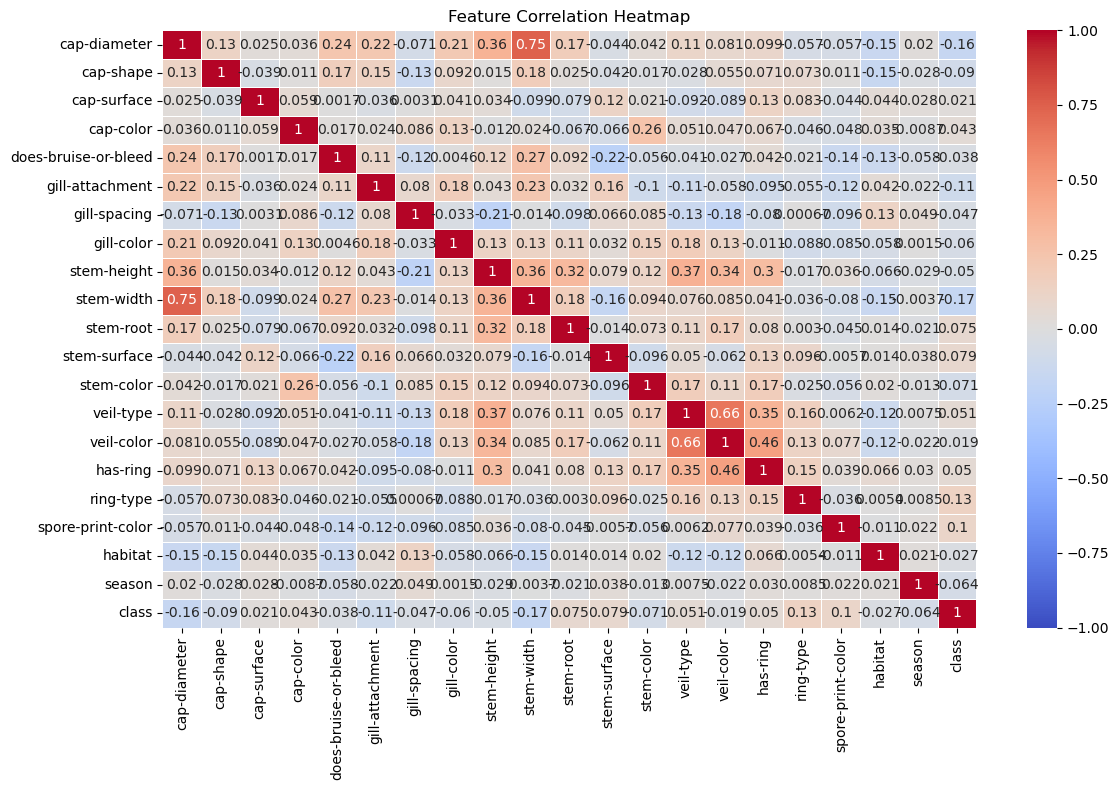

In [26]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

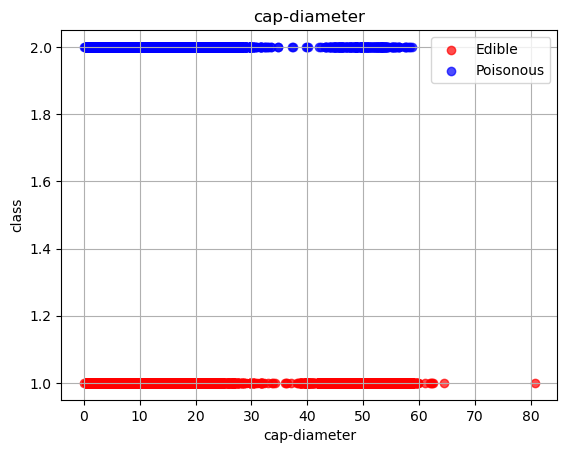

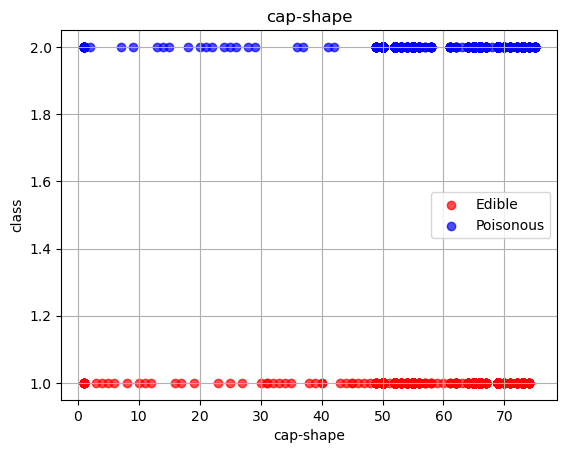

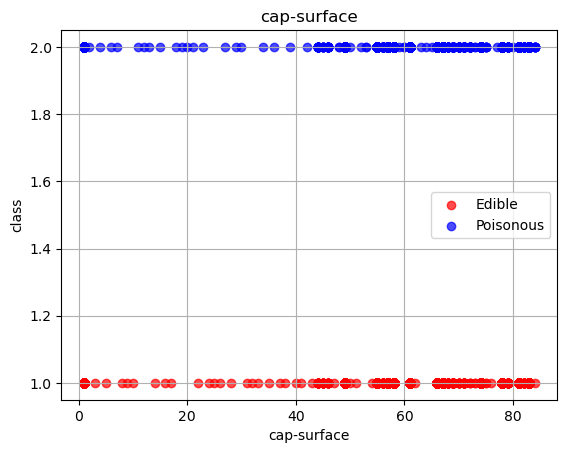

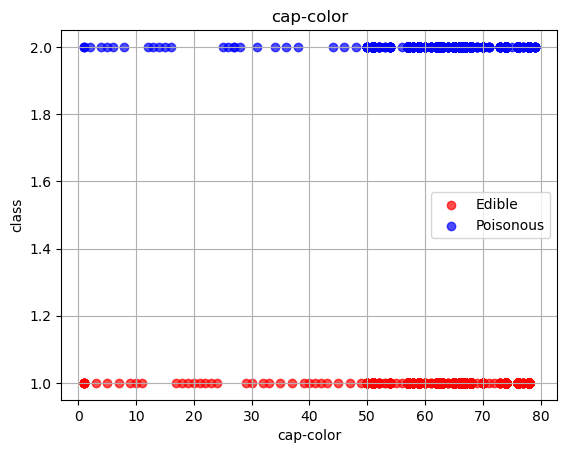

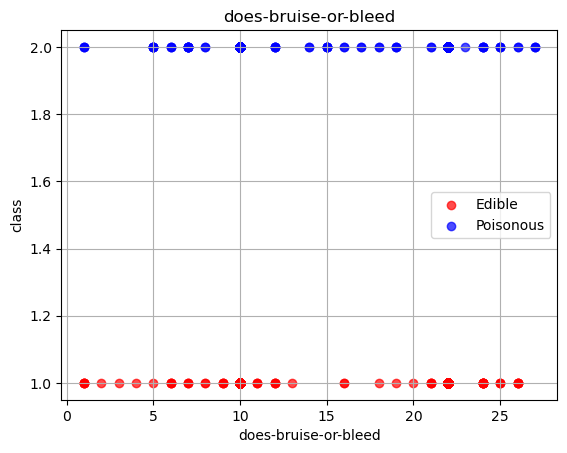

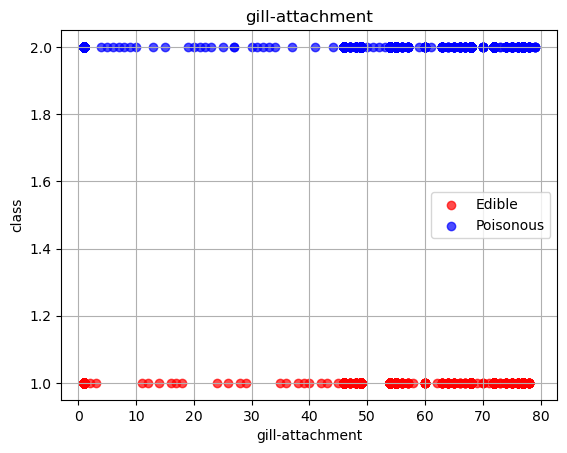

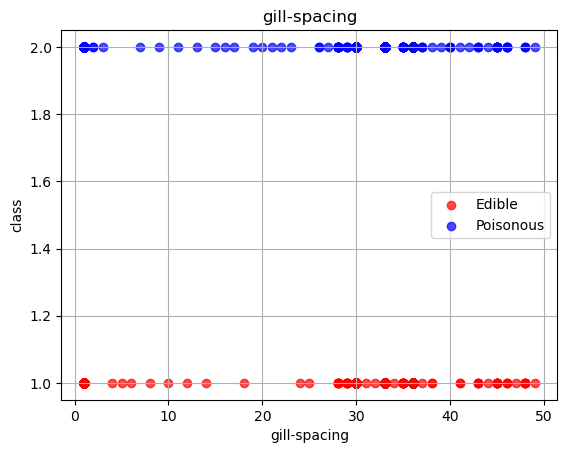

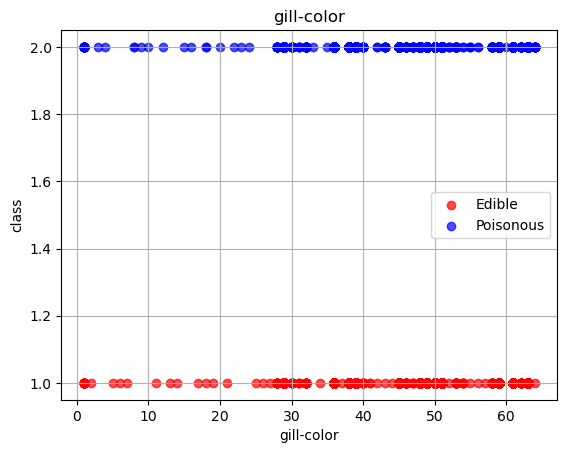

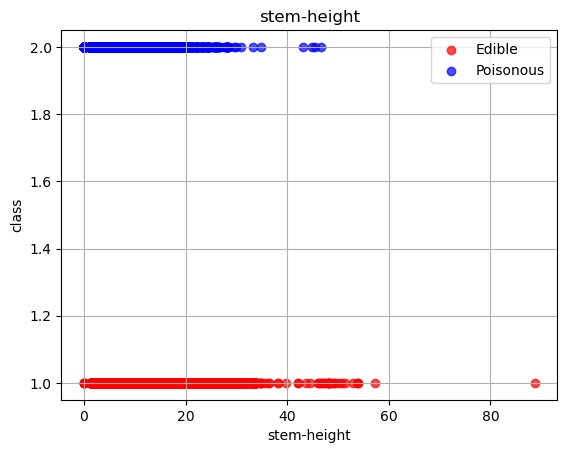

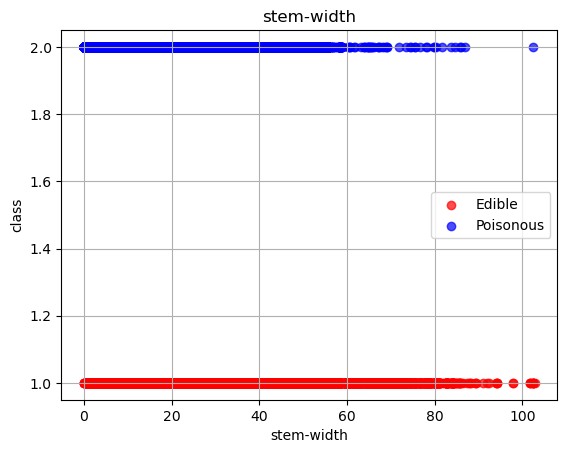

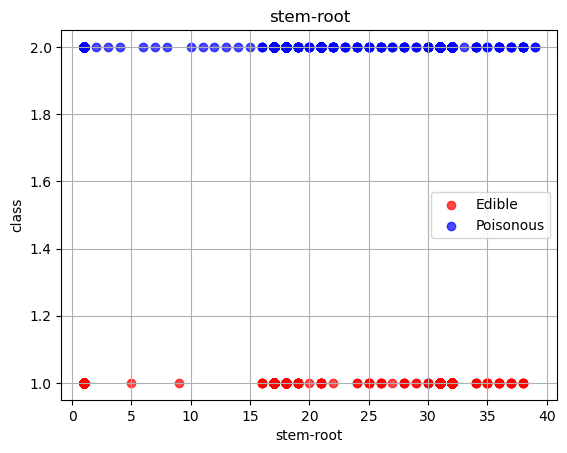

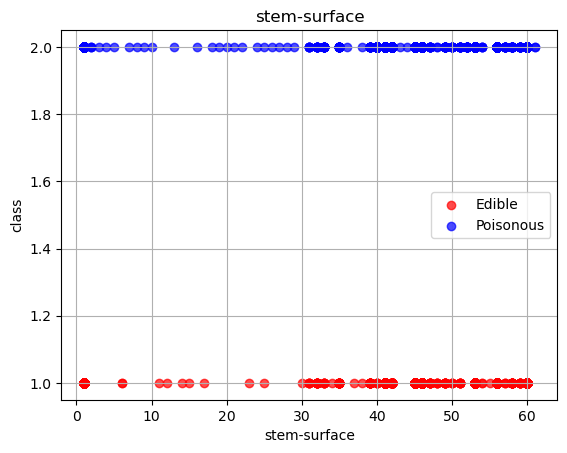

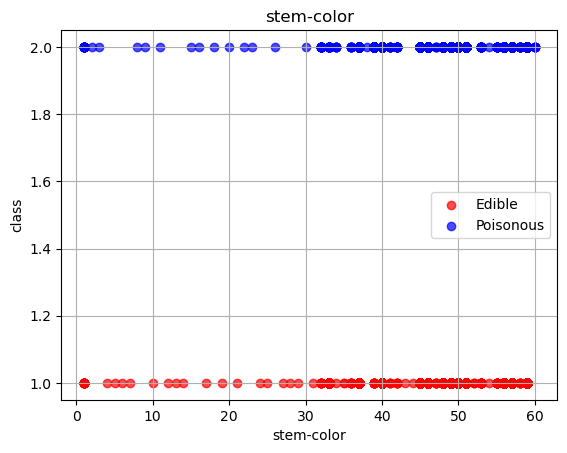

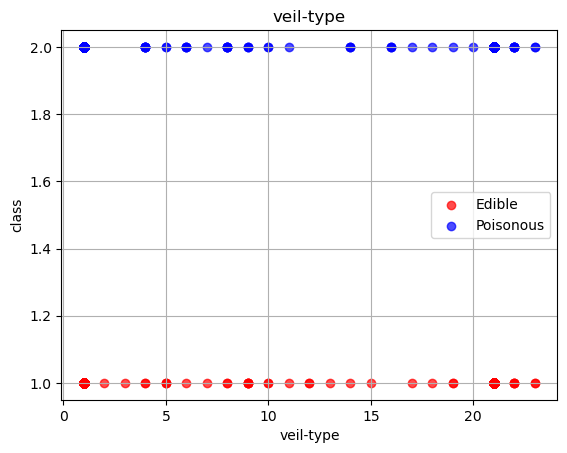

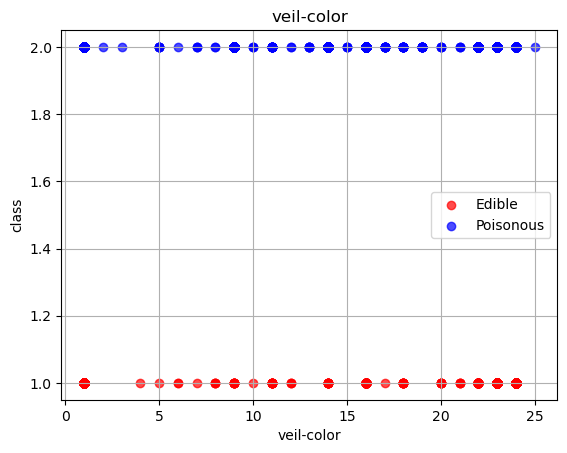

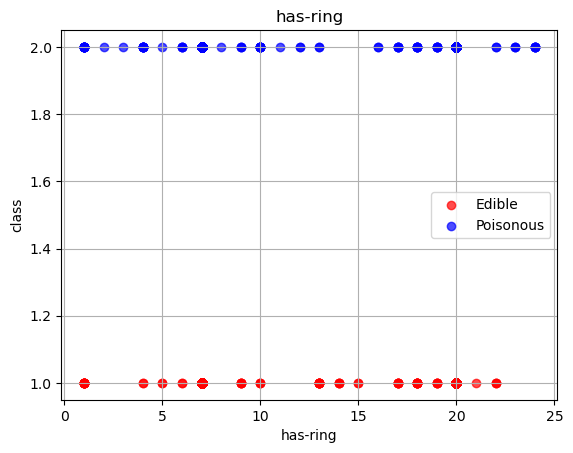

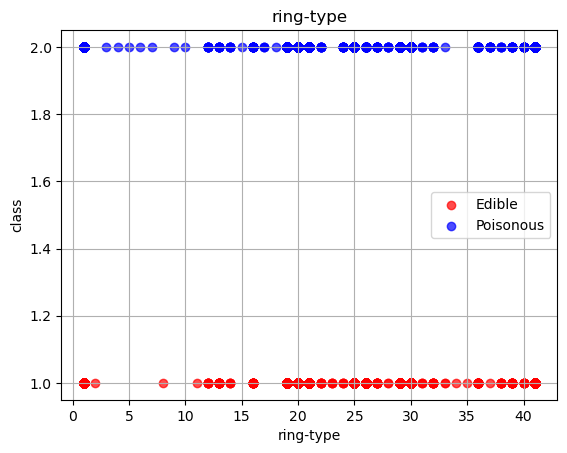

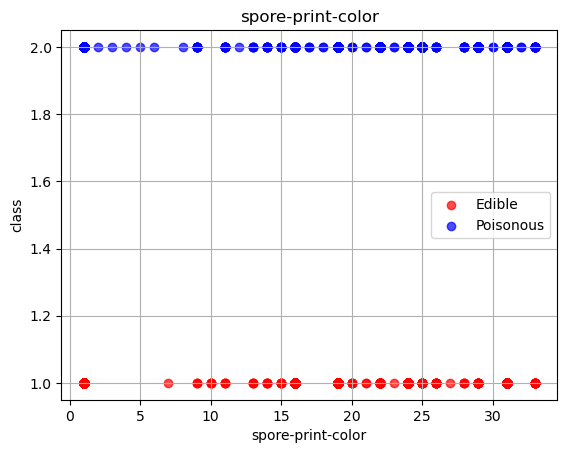

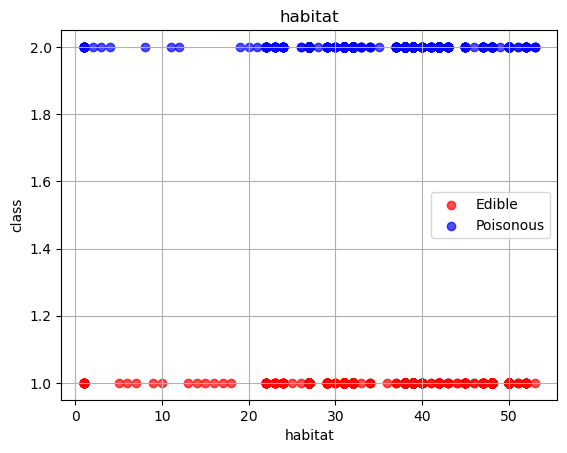

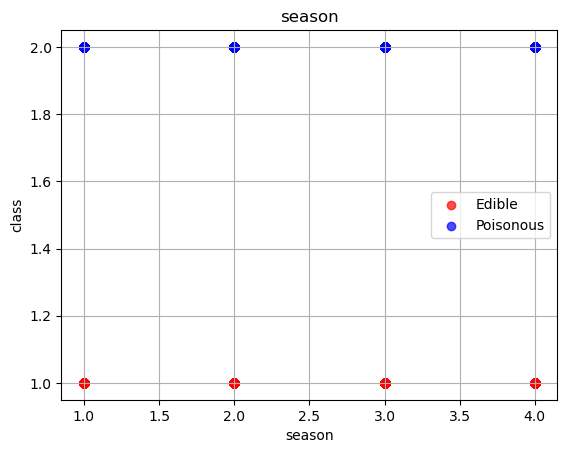

In [ ]:
# Plotting scatter training data for relevancy 

def scatter():
    numerical_columns = train.select_dtypes(include=['int64', 'float16']).columns
    for column in numerical_columns[:-1]:
        plt.figure()
        plt.scatter(train[train['class'] == 1][column], train[train['class'] == 1]['class'], label='Edible', color='red', alpha=0.7)
        plt.scatter(train[train['class'] == 2][column], train[train['class'] == 2]['class'], label='Poisonous', color='blue', alpha=0.7)
        plt.legend()
        plt.title(column)
        plt.ylabel('class')
        plt.xlabel(column)
        plt.grid()
        plot_path = f"{_plots}{column}_scatter.jpg"
        plt.savefig(plot_path)
        plt.show()

scatter()

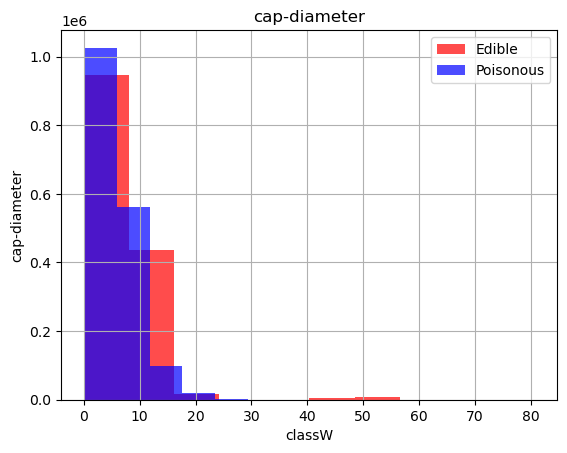

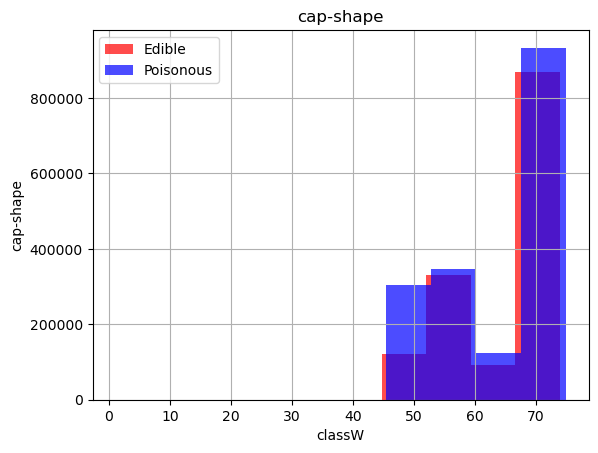

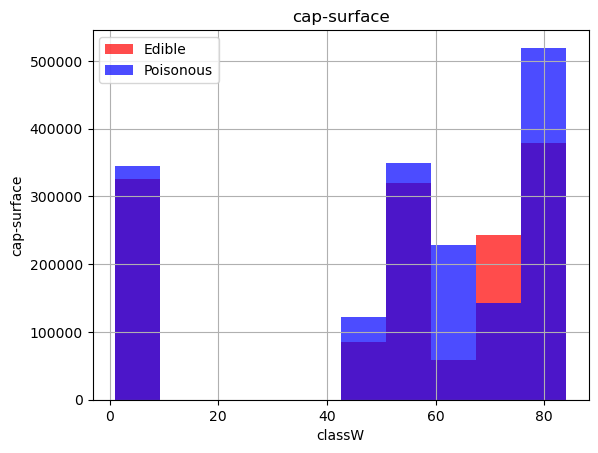

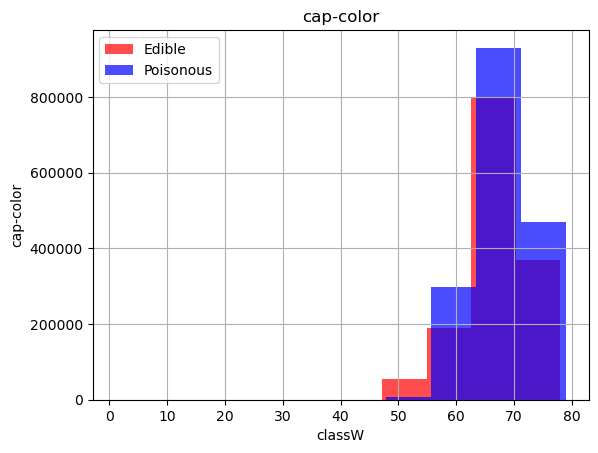

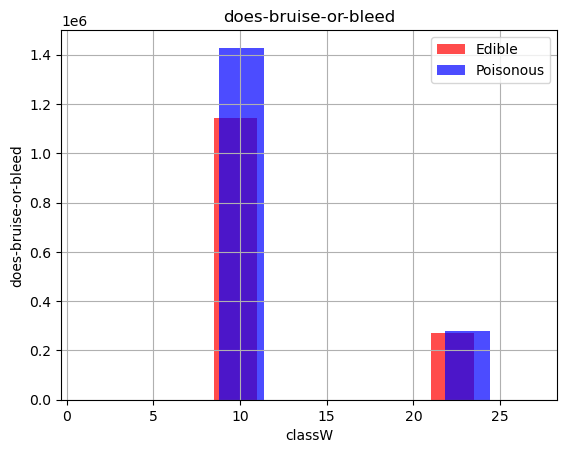

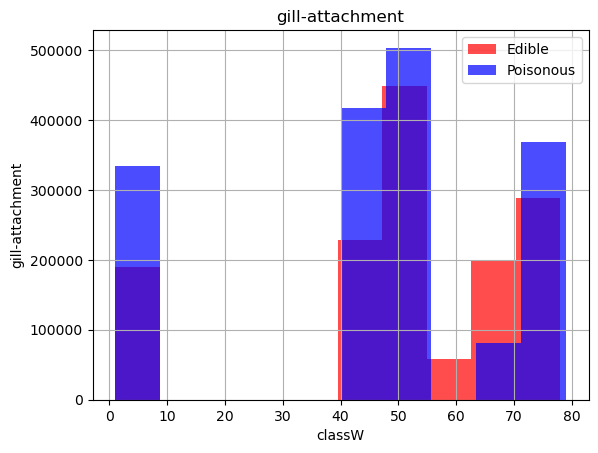

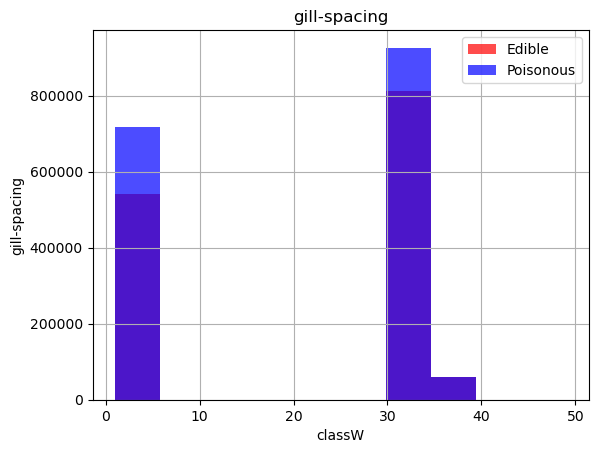

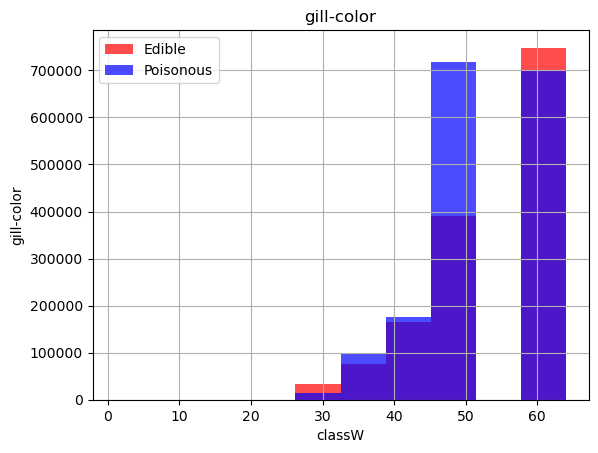

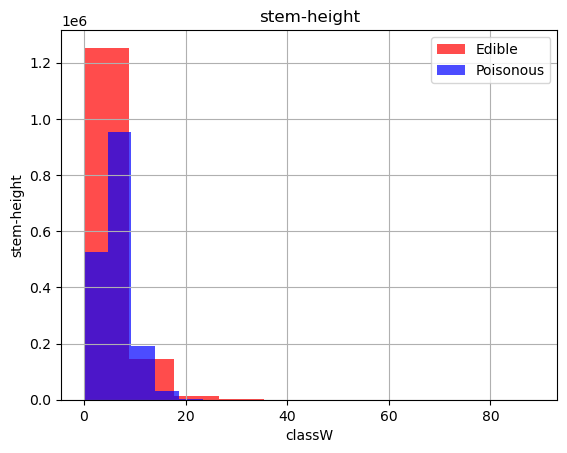

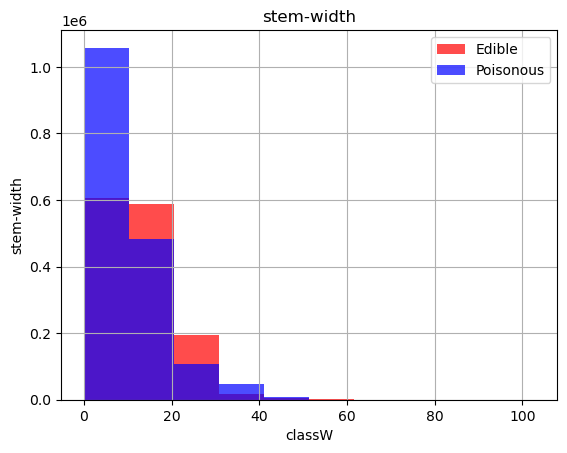

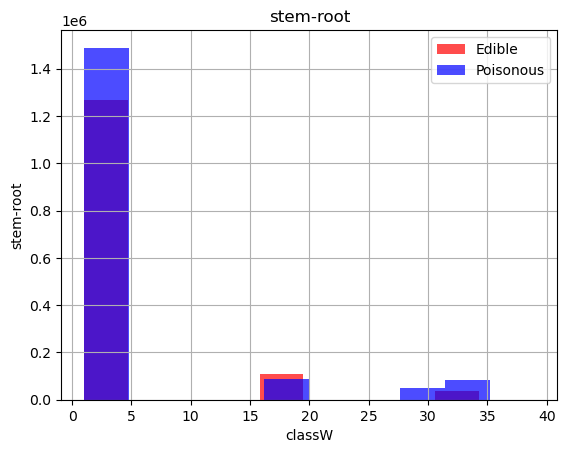

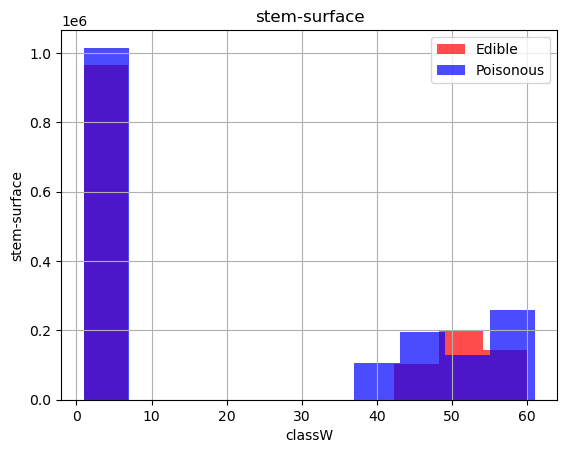

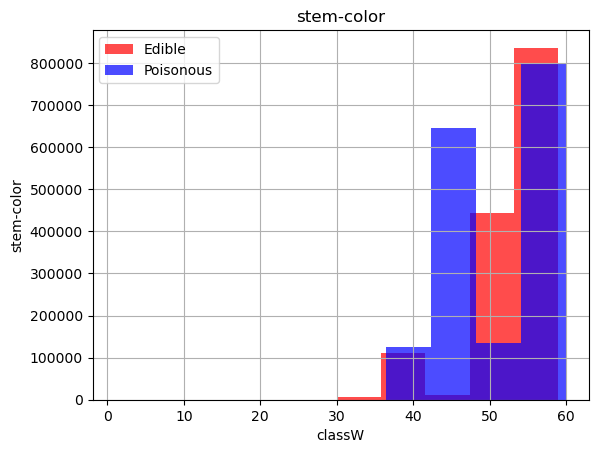

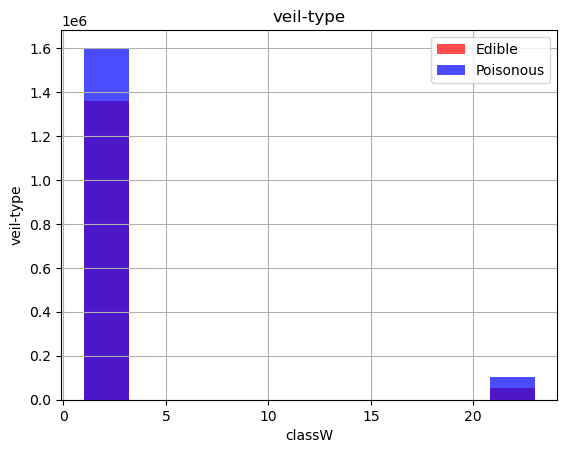

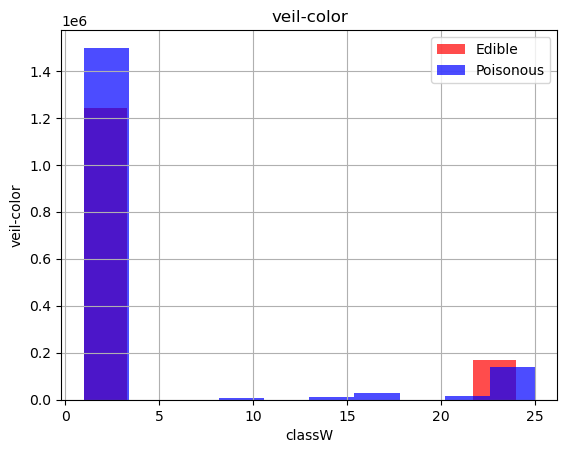

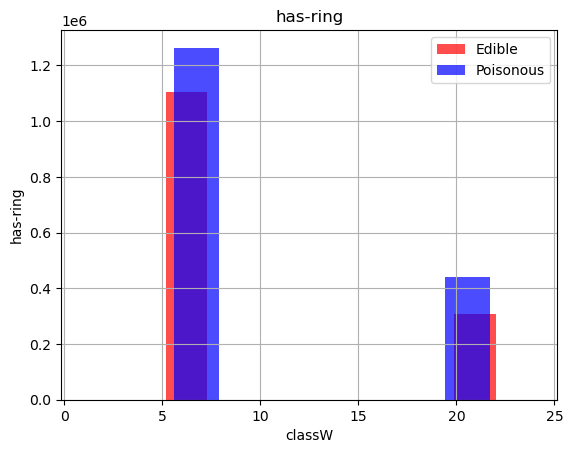

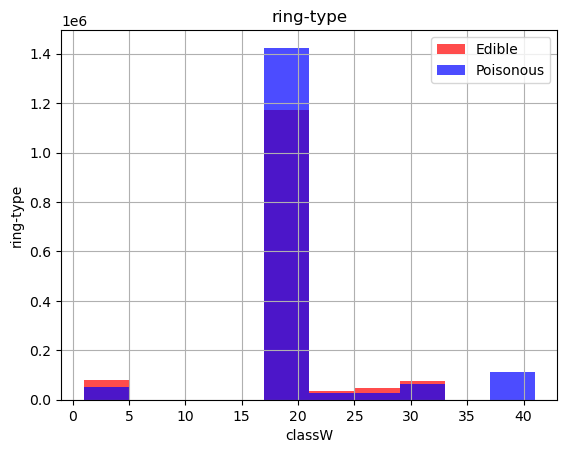

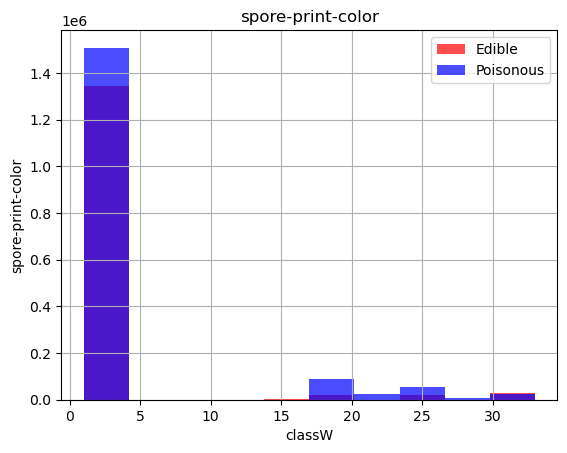

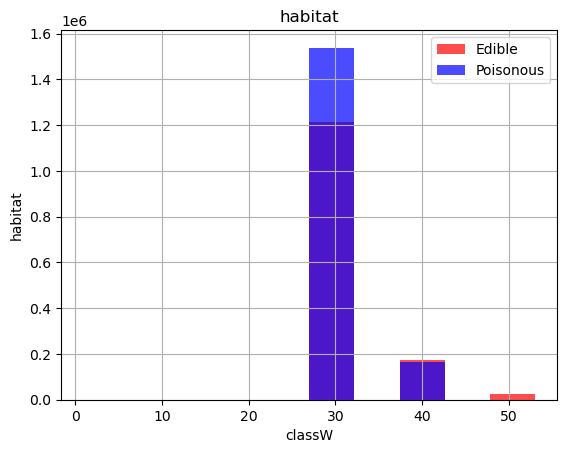

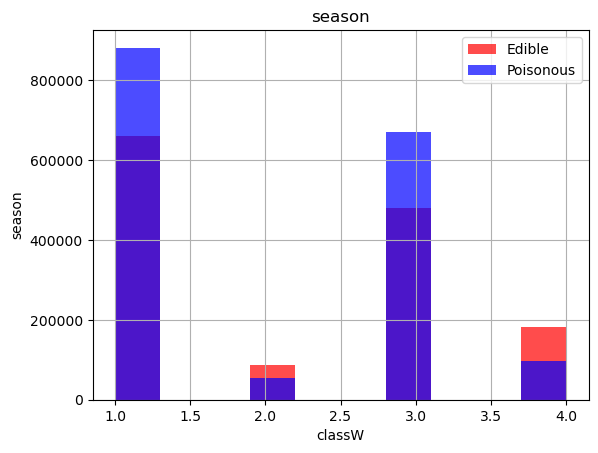

In [22]:
# Plotting histogram training data for relevancy 

def histogram():
    numerical_columns = train.select_dtypes(include=['int64', 'float16']).columns
    for column in numerical_columns[:-1]:
        plt.figure()
        plt.hist(train[train['class'] == 1][column], label='Edible', color='red', alpha=0.7, density=False)
        plt.hist(train[train['class'] == 2][column], label='Poisonous', color='blue', alpha=0.7, density=False)
        plt.legend()
        plt.title(column)
        plt.ylabel(column)
        plt.xlabel('classW')
        plt.grid()
        plot_path = f"{_plots}{column}_histogram.jpg"
        plt.savefig(plot_path)  
        plt.show()

histogram()

<AxesSubplot: xlabel='class', ylabel='count'>

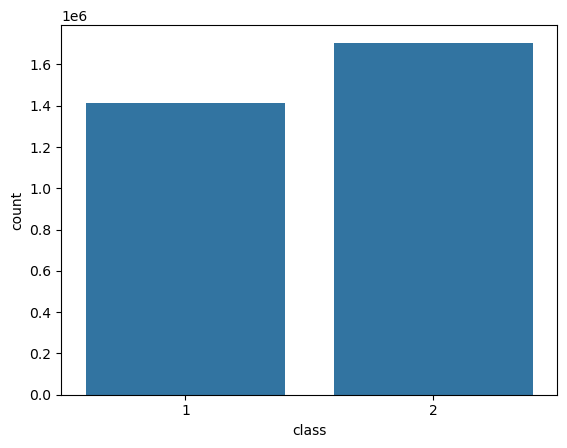

In [43]:
# Plot distribution of target col
sns.countplot(data=train, x='class')

# K-NearestNeighboor Model 

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print(classification_report(y_test, knn_pred))

# Gaussian Naive Bayes Model 

In [38]:
from sklearn.naive_bayes import GaussianNB

In [40]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           1       0.55      0.68      0.61    282463
           2       0.67      0.54      0.60    340926

    accuracy                           0.61    623389
   macro avg       0.61      0.61      0.61    623389
weighted avg       0.62      0.61      0.61    623389



# Logistic Regression Model

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           1       0.62      0.53      0.57    282463
           2       0.65      0.73      0.69    340926

    accuracy                           0.64    623389
   macro avg       0.64      0.63      0.63    623389
weighted avg       0.64      0.64      0.64    623389

